<h1>Проект "Телеком"</h1>

<b>Краткое описание задачи:</b> Оператор связи в последние месяцы наблюдает отток клиентов. Необходимо научиться его прогнозировать. При этом важно учитывать, что для сохранения клиента в компании будут предприниматься определенные меры, которые связаны с определенными затратами, клиентам, которые могут уйти, будут предлагать скидки. Поэтому важна не только полнота результата, но еще и точность. <br>
<b>Цель проекта: </b>провести исследовательский анализ данных и дать некоторые рекомендации, обучить модель высокого качества <br>
<b>Задачи проекта: </b>
1. Открыть файлы, изучить данные
2. Провести исследовательский анализ данных, сформировать рекомендации на его основании
3. Подготовить признаки: убрать лишние, провести кодирование и стандартизацию
4. Обучить несколько моделей и выбрать лучшую

In [82]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\геннадий\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


Сделаем все необходимые импорты

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats as st
import phik
RANDOM_STATE = 12345
import warnings 
warnings.filterwarnings('ignore')
from dateutil import relativedelta as rdelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, f1_score, roc_auc_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
CURRENT_DATE = dt.datetime(2020,2,1,0,0,0)

<h2>Открытие файлов и предобработка данных</h2>

Откроем файлы и изучим их. Проверим и преобразуем типы данных

<h4>Contract</h4>

In [84]:
def open_file_info(path,file_name):#функция для открытия файлов и вывода общей информации и нескольких строк
    file=pd.read_csv(path)
    print('\033[1m' + 'ИНФОРМАЦИЯ О ФАЙЛЕ '+file_name + '\033[0m')
    print('Пример содержимого файла')
    display(file.sample(10,random_state = RANDOM_STATE))
    print('Общая информация о файле')
    print(file.info())
    return file

#FILEPATH =  'datasets/final_provider/'   
FILEPATH =  'datasets/final_provider/'   
contract = open_file_info(FILEPATH +'contract.csv','CONTRACT')


ИНФОРМАЦИЯ О ФАЙЛЕ CONTRACT
Пример содержимого файла


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1128,0098-BOWSO,2017-11-01,No,Month-to-month,Yes,Electronic check,19.40,529.8
2875,9992-RRAMN,2018-02-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.10,1873.7
1783,8380-PEFPE,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,71.65,71.65
3804,9773-PEQBZ,2019-04-01,No,Month-to-month,No,Electronic check,79.85,797.25
6087,8319-QBEHW,2017-12-01,No,One year,Yes,Bank transfer (automatic),39.95,1023.75
2071,3392-EHMNK,2014-07-01,No,Two year,No,Credit card (automatic),94.10,6302.8
2395,6486-LHTMA,2017-07-01,No,One year,Yes,Electronic check,90.70,2835.5
4660,0883-EIBTI,2019-10-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,19.50,31.55
372,6122-EFVKN,2018-02-01,No,Two year,No,Mailed check,35.75,830.8
1143,2446-ZKVAF,2018-08-01,No,Month-to-month,No,Credit card (automatic),56.80,1074.65


Общая информация о файле
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


Датасет Contract содержит 7043 записи, без пропусков.<br>
Содержит следующую информацию в следующих форматах:
 - customerID - уникальный идентификатор пользователя. Содержит цифры и симовлы латиницы. Тип данныъ object, что вполне уместно в данном случае
 - BeginDate - дата заключения договора. Пропусков поле не содержит, однако его тип данных - object, вероятнее всего, наиболее приемлемым вариантом мог бы стать тип данных DateTime. Ниже проанализируем датасет подробнее и примем решение о необходимости изменения типа данных
 - EndDate - дата завершения договора. Очевидно, что эта дата указана для тех договров, где обслуживание завершено. В остальных случаях указано No. Здесь также тип данных object. 
 - Type - способ оплаты (каждый месяц или раз в 1-2 года)
 - PaperlessBilling - получает ли клиент электронный чек. Тип данных - object, что также, вероятно, является не лучшим вариантом. Решение о необходимости изменения типа данных на boolean примем позднее после проведения более детального анализа.
 - PaymentMethod - способ оплаты
 - MonthlyCharges - размер ежемесячных платежей (реальных, либо в пересчете на ежемесячные платежи для тарифов, оплачиваемых раз в 1-2 года). Тип данных - float, что весьма уместно в данной ситуации
 - TotalCharges - общая сумма, полученная от клиента. Тип данных - object - необходимо выяснить, почему он такой (например, веротяно, где-то есть нечисловые значения), и при необходимости изменить

Проанализируем содержимое столбцов

In [85]:
print('Столбец customerID')
display(contract['customerID'].unique())
print('Количество уникальных значений: ',len(contract['customerID'].unique()))

Столбец customerID


array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

Количество уникальных значений:  7043


Как и предполагалось, столбец CustomerId содержит уникальные идентификаторы клиентов, у каждого клиента - только 1 договор. 

In [86]:
print('уникальные значения в столбце BeginDate')
contract['BeginDate'].sort_values().unique()

уникальные значения в столбце BeginDate


array(['2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
       '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
       '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
       '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
       '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
       '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
       '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
       '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
       '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
       '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
       '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
       '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
       '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
       '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-

Столбец BeginDate содержит только даты. Соотвественно, можно изменить тип данных на datetime. Вероятно, может наблюдаться некоторая связь между годом/месяцем начала действия контракта и фактом того, ушел ли клиент. Вычислим соответствующие столбцы и позже проанализируем их необходимость.
Также можно заметить, что все BeginDate начинаются с 1 числа соответствующего месяца. Можно сказать, что все контракты начинают свое действие именно с начала месяца

In [87]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
print('Тип данных изменен и столбцы созданы')

Тип данных изменен и столбцы созданы


In [88]:
print('уникальные значения в столбце EndDate')
contract['EndDate'].sort_values().unique()

уникальные значения в столбце EndDate


array(['2019-10-01 00:00:00', '2019-11-01 00:00:00',
       '2019-12-01 00:00:00', '2020-01-01 00:00:00', 'No'], dtype=object)

Как можно видеть, столбец EndDate содержит либо даты завершения контрактов, либо "No" - для контрактов, которые еще в силе. Соответственно, данный столбец может послужить источником для формирования целевого признака, а также также признака 'количество дней в контракте'<br>
Также можно заметить интересную особенность: во всем датасете (свыше 7000 записей) есть только 4 дня, в которые завершалось действие контракта. А если говорить еще точнее - это первые числа последних 4 месяцев. То есть реальный отток начался 4 месяца назад, до этого клиенты не уходили

Выделим колонку с целевым признаком и посчитаем "количество дней в контракте". 

In [89]:
contract['Quit'] = np.where(contract['EndDate'] != 'No',1,0)
contract['EndDate'] = np.where(contract['EndDate'] != 'No',contract['EndDate'],None)
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')
print('Преобразование произведено успешно')

Преобразование произведено успешно


In [90]:
#Функция для подсчета количества дней действия контракта. Если контракт еще не завершен, используется CURRENT_DATE
def count_current_days(ds): 
    end_date = ds['EndDate']
    begin_date = ds['BeginDate']
    #y = dt.date('NaT')
    if pd.isnull(end_date):    
        result = CURRENT_DATE - begin_date
    else:
        result = end_date - begin_date
    return result

contract['LongContract'] = contract.apply(count_current_days,axis=1)
contract['LongContract'] = contract['LongContract'].dt.days
contract.head()    

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,LongContract
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


Преобразование типов данных произведено. Позже оценим влияние полученных признаков на целевой

In [91]:
contract['Type'].sort_values().unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

Столбец Type не содержит значений, которых нет в списке. Для обучения моделей данный столбец в будущем преобразуем методом OHE

In [92]:
contract['PaperlessBilling'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

Столбец PaperlessBilling содержит только 2 значения - Yes, No. Заменим их на 1 и 0 соответственно

In [93]:
contract['PaperlessBilling'] = np.where(contract['PaperlessBilling']=='Yes',1,0)
print('Замена значений произведена успешно')

Замена значений произведена успешно


In [94]:
contract['PaymentMethod'].sort_values().unique()

array(['Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check'], dtype=object)

Столбец PaymentMethod содержит 4 различные значения. Данный столбец будем кодировать методом OHE для обучения моделей

Столбец MonthlyCharges имеет числовой тип данных, соответственно, можно просто проверить значения на наличие неотрицательных значений:

In [95]:
print('Min Monthly Charges: ',contract['MonthlyCharges'].min())
print('Max Monthly Charges: ',contract['MonthlyCharges'].max())

Min Monthly Charges:  18.25
Max Monthly Charges:  118.75


Значения в столбце Monthly Charges не выходят за рамки допустимых.

In [96]:
contract['TotalCharges'].sort_values().unique()

array([' ', '100.2', '100.25', ..., '999.45', '999.8', '999.9'],
      dtype=object)

Можно видеть, что в столбце TotalCharges есть пустые значения. Проверим эти значения

In [97]:
contract.query('TotalCharges == " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,LongContract
488,4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,NaT,Two year,0,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,0,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,2020-02-01,NaT,Two year,0,Mailed check,19.85,,0,0
3826,3213-VVOLG,2020-02-01,NaT,Two year,0,Mailed check,25.35,,0,0
4380,2520-SGTTA,2020-02-01,NaT,Two year,0,Mailed check,20.00,,0,0
5218,2923-ARZLG,2020-02-01,NaT,One year,1,Mailed check,19.70,,0,0
6670,4075-WKNIU,2020-02-01,NaT,Two year,0,Mailed check,73.35,,0,0


можно видеть, что в столбце TotalCharges есть пропущенные значения. Однако, можно видеть, что это все для договоров, заключенныъ на 01.02.2020. Как известно, информация о договорах актуальна именно ена 01.02.2020. То есть это просто новые договоры. Для них пропущенные значения можно заменить нулем

In [98]:
contract['TotalCharges']=np.where(contract['TotalCharges'] == ' ',0,contract['TotalCharges'])
contract['TotalCharges'] = contract['TotalCharges'].astype('float')
print('Преобразования успешно завершены')
display(contract.head())
print(contract.info())

Преобразования успешно завершены


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,LongContract
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,61


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int32         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Quit              7043 non-null   int32         
 9   LongContract      7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(2), int64(1), object(3)
memory usage: 495.3+ KB
None


<h4>Personal</h4>

In [99]:
personal = open_file_info(FILEPATH +'personal.csv','PERSONAL')

ИНФОРМАЦИЯ О ФАЙЛЕ PERSONAL
Пример содержимого файла


,customerID,gender,SeniorCitizen,Partner,Dependents
1128,0098-BOWSO,Male,0,No,No
2875,9992-RRAMN,Male,0,Yes,No
1783,8380-PEFPE,Male,0,No,Yes
3804,9773-PEQBZ,Male,0,No,No
6087,8319-QBEHW,Male,0,No,Yes
2071,3392-EHMNK,Female,0,Yes,Yes
2395,6486-LHTMA,Female,1,Yes,No
4660,0883-EIBTI,Female,0,No,No
372,6122-EFVKN,Male,0,No,Yes
1143,2446-ZKVAF,Male,0,Yes,No


Общая информация о файле
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


Датасет personal содержит персональную информацию о клиентах:
 - customerID - идентификатор пользователя
 - gender - пол
 - SeniorCitizen - является ли клиент представителем старшего поколения
 - Partner - вероятно, информация о том, есть ли клиента партнер по жизни
 - Dependents - информация о том, находится ли кто-либо на иждивении у клиента
 Примечательно, что все типы данных - object или int, хотя, похоже, что здесь наиболее приемлем будет числовой или булев тип данных. Ниже будет произведен более подробный анализ и принято решение об изменении типов данных.
 Также примечательно, что в датасете personal содержится такое же количество строк, как и в датасете Contract. Получается, что один клиент может иметь только 1 контракт

В этом и следующих датасетах довольно большое количество колонок со значениями YES/NO. Напишем функцию замены этих значений

In [100]:
def change_yes_no(df,column):
    uv = df[column].sort_values().unique()
    if len(uv) == 2 and uv[0] == 'No'and uv[1] == 'Yes':
        df[column] = np.where(df[column] == 'Yes', 1, 0)
        print('замена значений в столбце '+column+' произведена успешно')
    else:
        print('Набор значений в столбце '+column+' не соответствует [Yes,No]')
    return df[column]

In [101]:
personal['gender'].sort_values().unique()

array(['Female', 'Male'], dtype=object)

В данном случае считаю неуместным замену значений 0 и 1. Во-первых, это не булево поле, а чисто категориальное, причем здесь нет ранжирования значений. И теоретически в будущем может появиться допустимое 3 значение данного поля (уже сейчас многие чисто по идеологическим причинам не хотят указывать свой пол), очень хотелось бы, чтобы построенная модель была достаточно гибкой, чтобы учитывать этот вариант. Оставим данный признак как категориальный, и перед обучением моделей закодируем его

In [102]:
personal['SeniorCitizen'].sort_values().unique()

array([0, 1], dtype=int64)

признак SeniorCitizen содержит всего 2 значения и не нуждается в перекодировании

In [103]:
YNColumns = ['Partner','Dependents']
for column in YNColumns:
    personal[column] = change_yes_no(personal,column)

personal.head()

замена значений в столбце Partner произведена успешно
замена значений в столбце Dependents произведена успешно


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0


<h4>Internet</h4>

In [104]:
internet = open_file_info(FILEPATH +'internet.csv','INTERNET')

ИНФОРМАЦИЯ О ФАЙЛЕ INTERNET
Пример содержимого файла


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4878,7823-JSOAG,Fiber optic,No,No,No,No,No,No
5002,4450-YOOHP,DSL,No,No,Yes,No,Yes,Yes
4160,2498-XLDZR,DSL,Yes,Yes,Yes,Yes,No,Yes
683,7905-TVXTA,DSL,Yes,No,No,Yes,Yes,No
1930,9802-CAQUT,Fiber optic,Yes,Yes,Yes,No,Yes,Yes
2140,3387-VATUS,Fiber optic,No,No,No,No,Yes,Yes
2311,2845-AFFTX,Fiber optic,No,No,Yes,No,Yes,Yes
3417,0853-NWIFK,Fiber optic,Yes,Yes,No,No,Yes,Yes
1472,0973-KYVNF,DSL,Yes,Yes,Yes,No,Yes,No
4716,9253-QXKBE,Fiber optic,No,No,No,No,Yes,Yes


Общая информация о файле
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


Датасет Internet содержит информацию об используемых интернет-сервисах:
 - InternetService	 - способ подключения
 - OnlineSecurity - использует ли клиент сервис "блокировка небезопасных сайтов"
 - OnlineBackup - использует ли клиент облачное хранилище
 - DeviceProtection - использует ли клиент антивирус
 - TechSupport - использует ли клиент выделенную линию тех.поддержки
 - StreamingTV - использует ли клиент сервис стримингового телевидения
 - StreamingMovies - использует ли клиент сервис каталога фильмов
 Все типы данных - object. Пропусков нет. Однако тип данных object не слишком уместен для всех столбцов, кроме CustomerId, In ternetService. Здесь наиболее уместным кажется тип boolean или float. Позднее произведем более подробный анализ ниже(возможно, в этих столбцах есть еще какие-то значения, кроме yes/no) <br>
 Колчество записей в данном датасете меньше, чем датасетах personal и contract - очевидно, здесь указаны только клиенты, которые  используют интернет - сервисы

In [105]:
internet['InternetService'].sort_values().unique()

array(['DSL', 'Fiber optic'], dtype=object)

Значения в столбце internetService категориальные, позднее закодируем их <br>
Произведем замену значений во всех остальных столбцах

In [106]:
YNColumns = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for column in YNColumns:
    internet[column] = change_yes_no(internet,column)
internet.head()

замена значений в столбце OnlineSecurity произведена успешно
замена значений в столбце OnlineBackup произведена успешно
замена значений в столбце DeviceProtection произведена успешно
замена значений в столбце TechSupport произведена успешно
замена значений в столбце StreamingTV произведена успешно
замена значений в столбце StreamingMovies произведена успешно


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


<h4>Phone</h4>

In [107]:
phone = open_file_info(FILEPATH +'phone.csv','PHONE')

ИНФОРМАЦИЯ О ФАЙЛЕ PHONE
Пример содержимого файла


,customerID,MultipleLines
1649,8966-KZXXA,Yes
1920,7206-PQBBZ,No
2852,4567-AKPIA,Yes
911,7047-YXDMZ,No
6259,7619-PLRLP,Yes
3581,1304-NECVQ,Yes
5992,9248-OJYKK,Yes
3169,2921-XWDJH,No
3903,9134-WYRVP,No
121,3774-VBNXY,No


Общая информация о файле
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


В датаесете phone содержится инфрмация о клиентах, пользующихся услугами стационарной телефонной связи. MultipleLines - поле, дающее информацию о том, использует ли клиент подключение телефона к нескольким линиям одновременно.

In [108]:
phone['MultipleLines'] = change_yes_no(phone,'MultipleLines')
phone.head()

замена значений в столбце MultipleLines произведена успешно


,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


<b>Вывод</b><br>Файлы открыты, данные изучены проверены на наличие пропусков. Значения в столбцах Yes/No заменены на 1/0.

<h2>Исследовательский анализ данных</h2>

<h3>Формирование признакового пространства</h3>

Так как у каждого пользователя может быть только 1 договор, можем совместить данные из таблицы contract и таблицы personal

In [109]:
data = contract.merge(personal,on='customerID')
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,LongContract,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,31,Female,0,1,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,1036,Male,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,61,Male,0,0,0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,61,Female,0,0,0


Пользователи пользуются различными сервисами. С целью анализа удобно было бы разделить их на группы. Например, в отношении использования телефонных сервисов, пользователей можно сразу разделить на 3 группы (в скобках можно указать кодирование польз):
- Не используют телефонный сервис (-1)
- Используют подключение только к одной линии (0)
- Используют подключение ко множеству линий (1)
Это можно сделать, присоединив к таблице data таблицу phone, заменив пропуски значением -1

In [110]:
data = data.join(phone.set_index('customerID'), on = 'customerID', how='left')
data['MultipleLines'] = data['MultipleLines'].fillna(-1)

В датасете internet 7 признаков. Возможно, мы можем кластеризовать пользователей в этом датасете и получить меньшее количество кластеров, чем количество признаков. Проверим это.

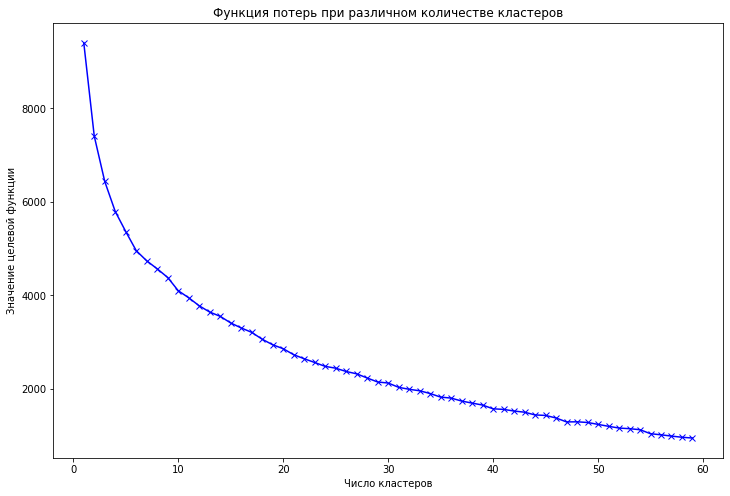

In [111]:
internet2 = internet.drop('customerID',axis = 1)

internet2['InternetService'] = np.where(internet2['InternetService'] == 'DSL',1,2)


distortion = []
K = range(1, 60)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(internet2)
    distortion.append(model.inertia_) 
    
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.title('Функция потерь при различном количестве кластеров')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show() 


Можем видеть, что значение целевой функции начинает уходить в плато только при количестве кластеров, близком к 60,а где-то до 20 кластеров скачки в значениях очень высоки. Таким образом, кластеризовать пользователей в данном случае совершенно нецелесообразно. Проще и точнее будет использовать имеющиеся признки путем присоединения таблицы internet к таблице data. Для пользователей, которые не используют соответствующие сервисы, заменим пропуски значением -1

In [112]:
data = data.join(internet.set_index('customerID'), on = 'customerID', how='left')
data['InternetService'] = data['InternetService'].fillna('NO USE')
for column in YNColumns:
    data[column] = data[column].fillna(-1)
data.sample(7,random_state = RANDOM_STATE)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,LongContract,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1128,0098-BOWSO,2017-11-01,NaT,Month-to-month,1,Electronic check,19.40,529.80,0,822,...,0,0,0.0,NO USE,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2875,9992-RRAMN,2018-02-01,2019-12-01,Month-to-month,1,Electronic check,85.10,1873.70,1,668,...,1,0,1.0,Fiber optic,0.0,0.0,0.0,0.0,0.0,1.0
1783,8380-PEFPE,2019-09-01,2019-10-01,Month-to-month,1,Electronic check,71.65,71.65,1,30,...,0,1,0.0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0
3804,9773-PEQBZ,2019-04-01,NaT,Month-to-month,0,Electronic check,79.85,797.25,0,306,...,0,0,1.0,Fiber optic,0.0,1.0,0.0,0.0,0.0,0.0
6087,8319-QBEHW,2017-12-01,NaT,One year,1,Bank transfer (automatic),39.95,1023.75,0,792,...,0,1,-1.0,DSL,0.0,1.0,0.0,0.0,1.0,0.0
2071,3392-EHMNK,2014-07-01,NaT,Two year,0,Credit card (automatic),94.10,6302.80,0,2041,...,1,1,1.0,Fiber optic,0.0,1.0,0.0,1.0,1.0,0.0
2395,6486-LHTMA,2017-07-01,NaT,One year,1,Electronic check,90.70,2835.50,0,945,...,1,0,1.0,Fiber optic,0.0,0.0,1.0,0.0,1.0,0.0


Для удобства проводимого анализа выделим в отдельный датасет пользователей, которые завершили свои контракты

In [113]:
quit_users = data.query('Quit == 1')
curr_users = data.query('Quit == 0')
quit_users.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,LongContract,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,61,...,0,0,0.0,DSL,1.0,1.0,0.0,0.0,0.0,0.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,61,...,0,0,0.0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,1,Electronic check,99.65,820.50,1,245,...,0,0,1.0,Fiber optic,0.0,0.0,1.0,0.0,1.0,1.0
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,1,Electronic check,104.80,3046.05,1,853,...,1,0,1.0,Fiber optic,0.0,0.0,1.0,1.0,1.0,1.0
13,0280-XJGEX,2015-09-01,2019-10-01,Month-to-month,1,Bank transfer (automatic),103.70,5036.30,1,1491,...,0,0,1.0,Fiber optic,0.0,1.0,1.0,0.0,1.0,1.0


Определим, какую долю во всем датасете составляют ушедшие и оставшиеся клиенты:


Общее количество ушедших клиентов:  1869
Доля ушедших клиентов: 26.54%


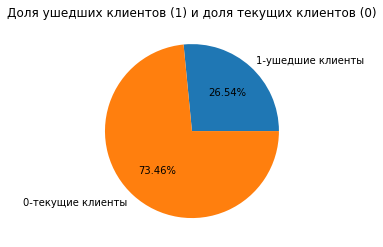

In [114]:
count_quits = data['Quit'].sum()
quits_percent = count_quits / data.shape[0]
print('Общее количество ушедших клиентов: ', count_quits)
print('Доля ушедших клиентов: {:.2%}'.format(quits_percent))
vals = [quits_percent,1-quits_percent]
labels=['1-ушедшие клиенты','0-текущие клиенты']

plt.pie(vals, labels=labels , autopct='%1.2f%%')
plt.title('Доля ушедших клиентов (1) и доля текущих клиентов (0)')
plt.show()


Можно видеть явный дисбаланс классов. 26,5% клиентов завершили взаимодействие с компанией. Хотя, если учесть, что отток наблюдается только в течение последних 4 месяцев, то картина не самая обнадеживающая: необходимо срочно принимать меры

<h3>Анализ поведения клиентов в зависимости от различных факторов</h3>

Сравним распределения категориальных переменных для всех клиентов и для клиентов, которые завершили свои контракты (ушедшие клиенты)
<br>
Напишем функцию для отрисовки столбчатой диаграммы для различных столбцов

In [115]:
def print_bar_charts(data_full,data_quit,data_curr,column,xlabel,lr):
    
    print('\033[1m'+'Столбчатые диаграммы для столбца '+column+'('+xlabel+')'+'\033[0m')
    plt.figure(1)
    ax1 = plt.subplot2grid((1,2), (0,0))
    sns.countplot(x=column, hue="Quit" , data=data_full, ax = ax1)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('количество пользователей')
    ax1.set_title('Клиенты (количество), которые расторгли договр(1) и остались(0)')
    ax1.tick_params(labelrotation = lr)

    ax3 = plt.subplot2grid((1,2), (0,1))
    sns.countplot(x=column, data=data_full, ax = ax3)
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel('количество пользователей')
    ax3.set_title('Общее количество клиентов')
    ax3.tick_params(labelrotation = lr)
    
    plt.subplots_adjust(top=1, bottom=0.1, left=0.10, right=1.5, hspace=1, wspace=0.4)
    plt.show()


<h4>Анализ поведения клиентов в зависимости от типа оплаты</h4>

Столбчатые диаграммы для столбца Type(тип оплаты)


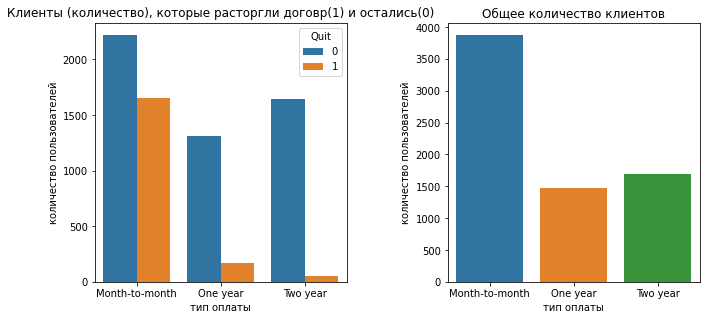

In [116]:
print_bar_charts(data,quit_users,curr_users,'Type','тип оплаты',0)

Можем видеть, что в большей степени уходят из компании клиенты, которые выбирали ежемесячный тип оплаты. Практически половина всех клиентов, которые выбирали тип оплаты "ежемесячный" предпочли покинуть компанию. Хотя в принципе данный тип оплаты является наиболее популярным. Вероятно, это связано с размером ежемесячных платежей. Также можно видеть, что среди клиентов, которые заключили договор на 1-2 года (периодичность платежей) также есть небольшой отток. При этом, несмотря на то, что общее количество клиентов, выбравших способ оплаты раз в 1 или 2 года примерно одинаково, клиенты, которые выбрали способ оплаты "раз в 2 года" уходят значительно медленнее. Здесь может играть роль как общий размер оплаты, в пересчете на ежемесячные платежи, так и тот факт, что срок действия их договора еще не истек, а фиксировать факт оттока клиента мы можем только после 6 месяцев отсутствия оплаты.<br>
Для начала изучим, каким образом размер ежемесячных платежей повлиял на факт ухода клиента:

Гистограммы распределения "Ежемесячный платеж" для ВСЕХ клиентов в зависимости от Тип оплаты------


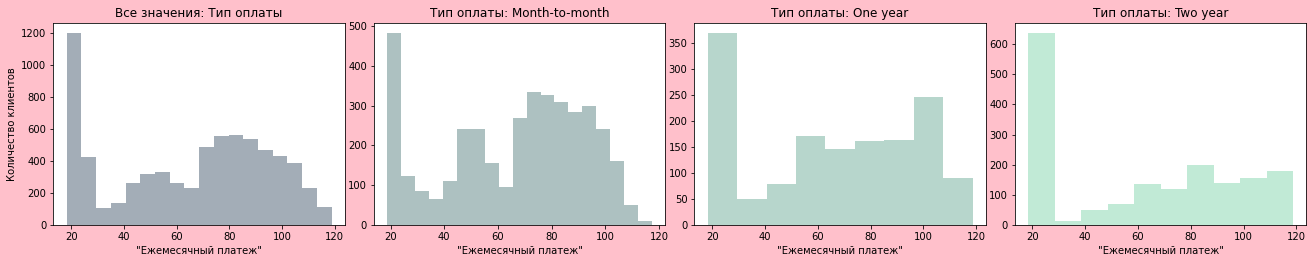

Гистограммы распределения "Ежемесячный платеж" для УШЕДШИХ клиентов в зависимости от Тип оплаты-------


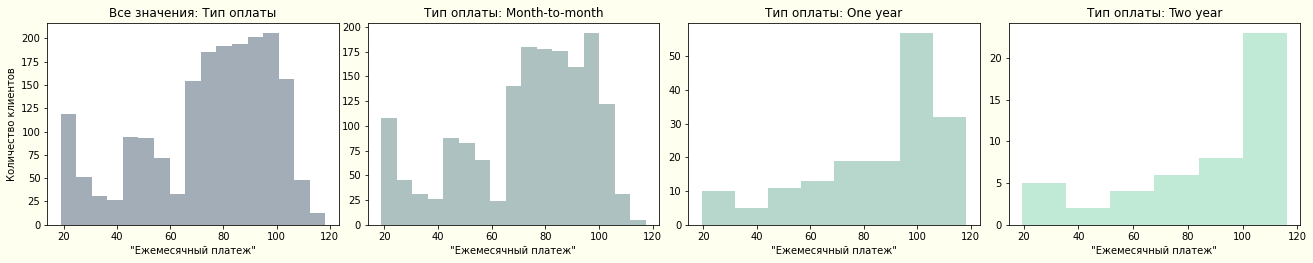

Гистограммы распределения "Ежемесячный платеж" ОСТАВШИХСЯ клиентов в зависимости от Тип оплаты-------


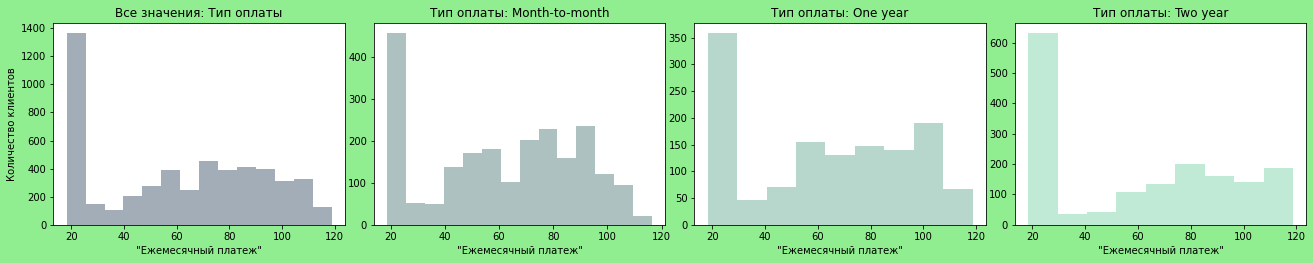

In [117]:
def add_subplots(data, column, num_column,expl,n_cols,un_list,n_rows,ttop,expl_gr): #функция для отрисовки гистограмм по типам
    color = (0.1, 0.2, 0.3)
    ax0 = plt.subplot2grid((n_rows,n_cols), (0,0))
    sns.distplot(a=data[num_column], norm_hist = False, kde = False, ax=ax0,color = color)
    ax0.set_title('Все значения: '+expl_gr)
    ax0.set_ylabel('Количество клиентов')
    ax0.set_xlabel(expl)
    for k in range(n_cols):
        if k>0:
            curr_col = un_list[k-1]         
            ax1 = plt.subplot2grid((n_rows,n_cols), (0,k))
           # color_new = 
            sns.distplot(a=data.query(column+' == "'+curr_col+'"')[num_column], norm_hist = False, kde = False, ax=ax1, color = (0.1+k/10,0.2+2*k/10,0.3+k/10))
            ax1.set_title(expl_gr+': '+curr_col)
            ax1.set_xlabel(expl)
    plt.subplots_adjust(top=ttop, bottom=0.1, left=0.10, right=3, hspace=0.7, wspace=0.1)
    plt.show()

def print_dist_hist(data, column,data_quit, data_curr, num_column,expl,expl_gr): #функция для отрисовки всех необходимых гистограмм
    n_rows = 1
    un_list = data[column].unique()
    n_cols = len(un_list) + 1 
    ttop = 0.8
    
    fig = plt.figure(1, facecolor = 'pink')
    print('\033[1m'+'Гистограммы распределения '+expl+' для ВСЕХ клиентов в зависимости от '+expl_gr+'------'+'\033[0m')
    add_subplots(data, column, num_column,expl,n_cols,un_list,n_rows,ttop,expl_gr)  
    
    plt.figure(1, facecolor = 'ivory')
    print('\033[1m'+'Гистограммы распределения '+expl+' для УШЕДШИХ клиентов в зависимости от '+expl_gr+'-------'+'\033[0m')
    add_subplots(data_quit, column, num_column,expl,n_cols,un_list,n_rows,ttop,expl_gr)
    
    
    plt.figure(1, facecolor = 'lightgreen')
    print('\033[1m'+'Гистограммы распределения '+expl+' ОСТАВШИХСЯ клиентов в зависимости от '+expl_gr+'-------'+'\033[0m')
    add_subplots(data_curr, column, num_column,expl,n_cols,un_list,n_rows,ttop,expl_gr)

print_dist_hist(data, 'Type', quit_users, curr_users,'MonthlyCharges','"Ежемесячный платеж"','Тип оплаты')


Как можно видеть, действительно, среди ушедших клиентов преобладает доля тех, чьи ежемесячные платежи достаточно высоки (от 70), в то время как среди оставшихся клиентов все больше тех, у кого маленькие ежемесячные платежи, так что ежемесячные затараты сыграли свою роль. Однако, размер ежемесячных платежей может зависеть также и от количества оказываемых услуг<br>

Мы видели, что среди тех клиентов, которые растогрли договор, наибольшее количество клиентов с типом оплаты Month-to month. Однако, хотелось бы понять, какие клиенты при этом преобладают: новые или те, кто с компанией уже давно.

Гистограммы распределения "Кол-во дней сотрудничества" для ВСЕХ клиентов в зависимости от Тип оплаты------


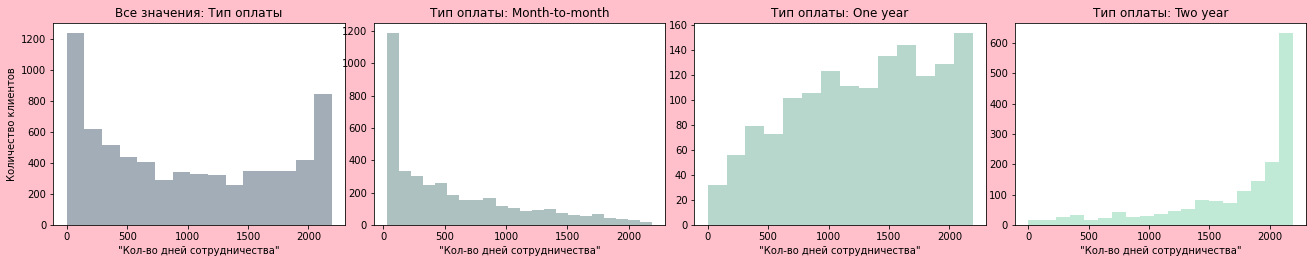

Гистограммы распределения "Кол-во дней сотрудничества" для УШЕДШИХ клиентов в зависимости от Тип оплаты-------


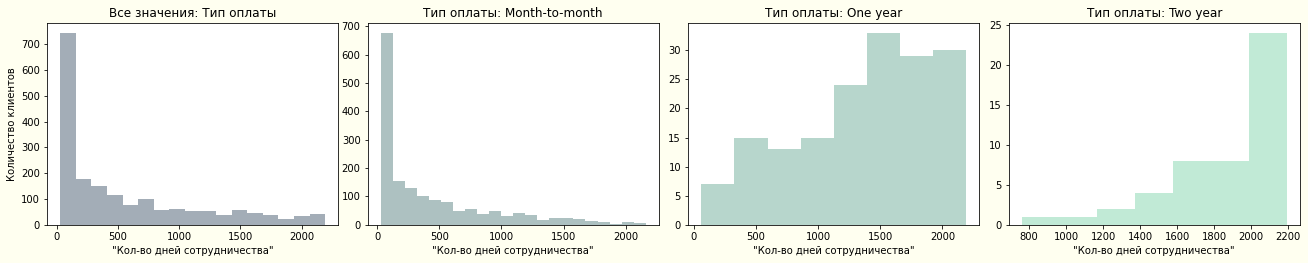

Гистограммы распределения "Кол-во дней сотрудничества" ОСТАВШИХСЯ клиентов в зависимости от Тип оплаты-------


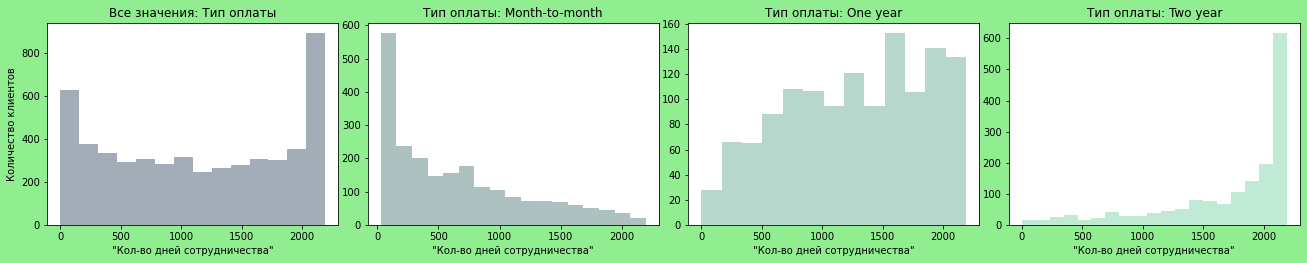

In [118]:
print_dist_hist(data, 'Type', quit_users, curr_users,'LongContract','"Кол-во дней сотрудничества"','Тип оплаты')

Как можно видеть на графике, среди уходящих клиентов преобладают новые, особенно они преобладают среди тех, у кого тип оплаты Month-to-month. Причем среди самых новых клиентов уходящих больше, чем остающихся. Однако среди клиентов, оплачивающих 1 раз в год или 1 раз в 2 года, уходят чаще те, кто дОльше был клиентом компании, однако их общее количество все же значительно меньше тех, кто остался. При этом также можно видеть, что среди клиентов, заключающих договор на длительный срок" больше тех, кто уже давно с компанией (больше 4 лет), однако все меньше новых клиентов заключают договор на длительный срок. <br>

<h4>Анализ поведения клиентов в зависимости от типа используемых услуг</h4>

Рассмотрим, какими услугами пользовались клиенты, которые ушли из компании

In [119]:
def get_pivot(data, group_set):    
    data_to_pivot = data[['Quit','Type','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]
    data_to_pivot['Additiional_IS'] = data_to_pivot['OnlineSecurity']+data_to_pivot['OnlineBackup']+data_to_pivot['DeviceProtection']+data_to_pivot['TechSupport']+data_to_pivot['StreamingTV']+data_to_pivot['StreamingMovies']
    data_to_pivot=data_to_pivot.drop(['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'],axis=1)
    data_to_pivot['Additiional_IS'] = np.where(data_to_pivot['Additiional_IS']<=0,'Not use','Use')
    data_to_pivot['MultipleLines'] = np.where(data_to_pivot['MultipleLines'] == -1,'NOT USE',np.where(data_to_pivot['MultipleLines'] == 0,'1 Line','Multiple lines'))
    pivot_data = pd.pivot_table(data_to_pivot, values='Quit', index=group_set, aggfunc='count', margins = True)
    return pivot_data
    
index_set = ['MultipleLines','InternetService']    
pivot_quit = get_pivot(quit_users,index_set)
pivot_curr = get_pivot(curr_users,index_set)

print('Количество клиентов')
merged = pivot_quit.merge(pivot_curr, on= index_set, suffixes = ['_quit','_curr'])
merged['Quit_all'] = merged['Quit_quit'] + merged['Quit_curr']
merged['Quit_quit_percent'] = (merged['Quit_quit'] / merged['Quit_all']) 
merged['Quit_curr_percent'] = (merged['Quit_curr'] / merged['Quit_all']) 
merged

Количество клиентов


Quit_quit  Quit_curr  Quit_all  \
MultipleLines  InternetService                                   
1 Line         DSL                    216        832      1048   
               Fiber optic            530        628      1158   
               NO USE                 103       1081      1184   
Multiple lines DSL                     73        618       691   
               Fiber optic            767       1171      1938   
               NO USE                  10        332       342   
NOT USE        DSL                    170        512       682   
All                                  1869       5174      7043   

                                Quit_quit_percent  Quit_curr_percent  
MultipleLines  InternetService                                        
1 Line         DSL                       0.206107           0.793893  
               Fiber optic               0.457686           0.542314  
               NO USE                    0.086993           0.913007  
Multiple lines DSL                       0.105644           0.894356  
               Fiber optic               0.395769           0.604231  
               NO USE                    0.029240           0.970760  
NOT USE        DSL                       0.249267           0.750733  
All                                      0.265370           0.734630

Как можно видеть, наибольшую долю ушедших клиентов составляют клиенты, пользующиеся услугами телефонной связи и оптоволокна. Причем почти половина всех клиентов, пользующихся этими услугами, ушла из компании. Даже у клиентов, пользующихся DSL, отток не такой большой. Встает вопрос, почему так активно уходят клиенты, пользующиеся оптоволоконной линией. Возможно, стоит проанализировать конкурентную рыночную стоимость и качество предоставляемых услуг. Тем более, если учесть, что самый активный отток у новых клиентов, использующих платежи Month-to-month, то, вероятнее, вопрос именно в соотношении цена/качество (не будь цена достаточно привлекательной, новые клиенты не приходили бы). Причем, если учесть,что среди клиентов, пользующихся услугами телефона (как с одной, так и с несколькими линиями), но не пользующихся услугами интернета, отток в процентном соотношении достаточно слабый, то можно предположить, что вопрос по большей части в качестве услуг оптоволоконной связи. 

Рассмотрим, есть ли корреляция между целевым признаком и фактом пользования услугами:

interval columns not set, guessing: ['Quit', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']


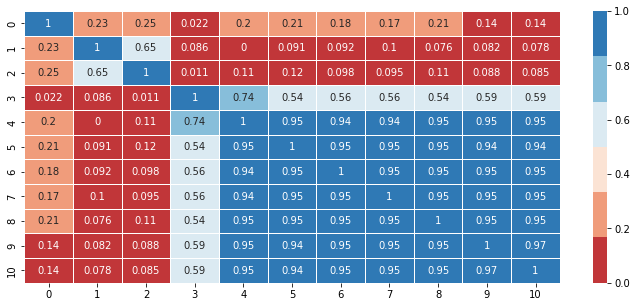

In [120]:
data_short = data[['Quit','Partner','Dependents','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]
data_short['InternetService'] = np.where(data_short['InternetService']=='DSL',1,np.where(data_short['InternetService']=='Fiber optic',0,-1))
phik_overview = data_short.phik_matrix()
phik_overview.round
plt.figure(figsize = (12,5))

sns.heatmap(phik_overview.values,cmap= sns.color_palette(palette="RdBu"),linewidths=0.5,annot=True)
plt.show()


Можем видеть, что у целевого признака достаточно слабая корреляция со всеми признаками, однако можем наблюдать достаточно сильную корреляцию между признаками, связанными с использованием интернет-сервисов. это говорит о том, что перед обученим модели можно будет создать некоторый комбинированный признак. 

<h4>Анализ поведения клиентов в зависимости от способа оплаты</h4>

Столбчатые диаграммы для столбца PaymentMethod(Способ оплаты)


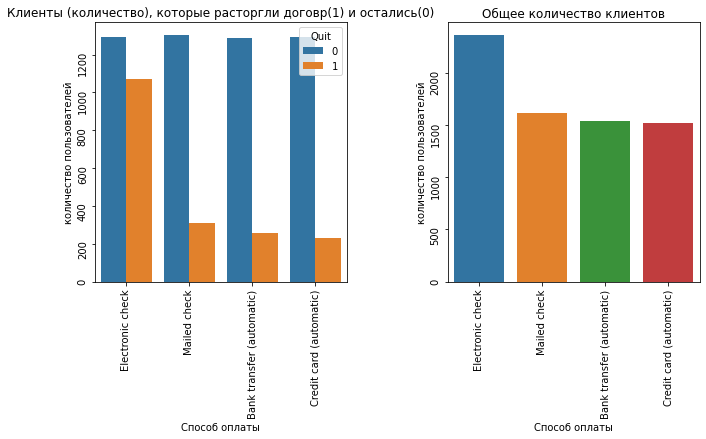

In [121]:
print_bar_charts(data,quit_users,curr_users,'PaymentMethod','Способ оплаты',90)

Можем видеть, что чаще всего уходят клиенты, которые используют тип оплаты Electronic check. Количество ушедших таким образом клиентов уже практически равно количеству оставшихся. При этом этот способ - самый популярный. Однако, если сравнивать с такими способами как bank transfer и credit card - наверняка он менее удобен, однако больше контролируется самим клиентом (он не автоматический), возможно, именно поэтому его выбирают чаще остальных. Все остальные методы примерно одинаковы по популярности, и отток клиентов там намного меньше

Гистограммы распределения "Кол-во дней сотрудничества" для ВСЕХ клиентов в зависимости от Способ оплаты------


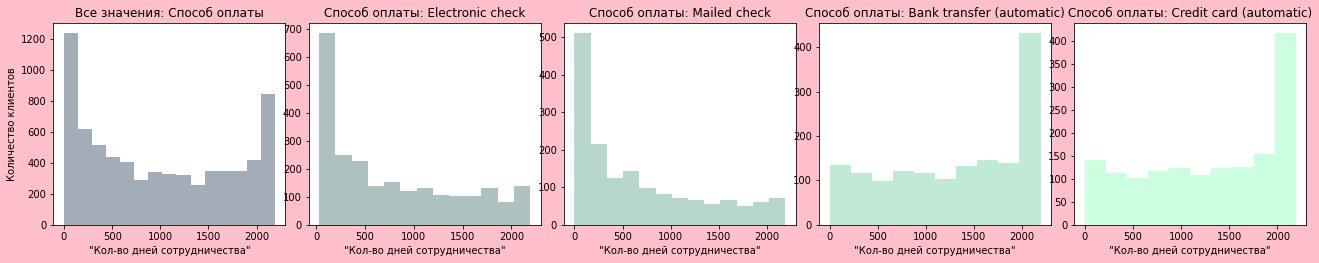

Гистограммы распределения "Кол-во дней сотрудничества" для УШЕДШИХ клиентов в зависимости от Способ оплаты-------


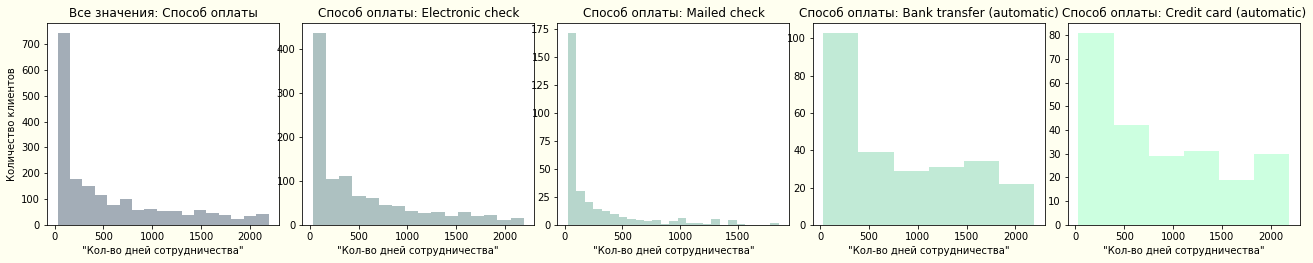

Гистограммы распределения "Кол-во дней сотрудничества" ОСТАВШИХСЯ клиентов в зависимости от Способ оплаты-------


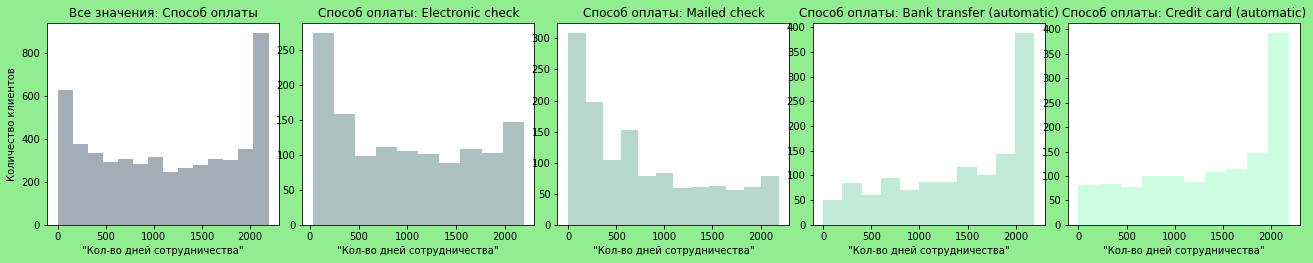

In [122]:
print_dist_hist(data, 'PaymentMethod', quit_users, curr_users,'LongContract','"Кол-во дней сотрудничества"','Способ оплаты')

Можео видеть, что значительная доля оттока для клиентов, использующих способ оплаты - Electronic check - это новые клиенты (таких даже больше, чем новых клиентов с таким типом оплаты, оставшихся в компании), среди клиентов, использующих Mailed Check также очень много новых клиентов, которые предпочли уйти от сотрудничества. Однако среди клиентов, использующих тип оплаты bank transfer или credit card, большинство - те, кто долго в компании. Среди таких клиентов отток "новеньких" также заметен, но в целом он ниже, чем при других способах оплаты. И в принципе наблюдается тенденция, что новые клиенты предполчитают Electronic check или Mailed Check, способы с автоплатежами им не слишком интересны. Вероятно, они боллее осторожны, и не хотят автоматизировать такую статью расходов, особенно, пока еще не уверены, останутся ли.

<b>Общий Вывод</b><br>
Было обнаружено, что значительная доля ушедших клиентов - новые клиенты, а также клиенты, пользующиеся услугами оптоволокна, и предпочитающих ежемесячный тип оплаты, а также клиенты, у которых высокий ежемесячный платеж. Если уходят новые клиенты, выбирающие конкретный сервис, то необходимо проанализировать соотношение цена/качество для данной услуги, либо цены, которые предлагает рынок: вполне возможно, что они имеют тенденцию к снижению, и бизнес недостаточно быстро на это реагирует.

<h2>Обучение и тестирование моделей</h2>

<h3>Подговтока признаков</h3>

In [123]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Quit,LongContract,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,31,...,1,0,-1.0,DSL,0.0,1.0,0.0,0.0,0.0,0.0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,1036,...,0,0,0.0,DSL,1.0,0.0,1.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,61,...,0,0,0.0,DSL,1.0,1.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371,...,0,0,-1.0,DSL,1.0,0.0,1.0,1.0,0.0,0.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,61,...,0,0,0.0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0


Предполагаем убрать признак EndDate: во-первых, есть пропущенные значения, а во вторых, все, что в нем есть, полностью покрывается 3 другими признаками: BeginDate + LongContract + Quit. Также совсем неи нформативен признак customerID. От него совсем никак не может зависеть, уйдет клиент или нет. Так что данный признак тоже можно удалить

In [124]:
data = data.drop(['EndDate','customerID'],axis = 1)
print('Признаки удалены успешно')

Признаки удалены успешно


Ранее мы уже рассматривали матрицу корреляции между признаками, для наглядности выведем снова: 

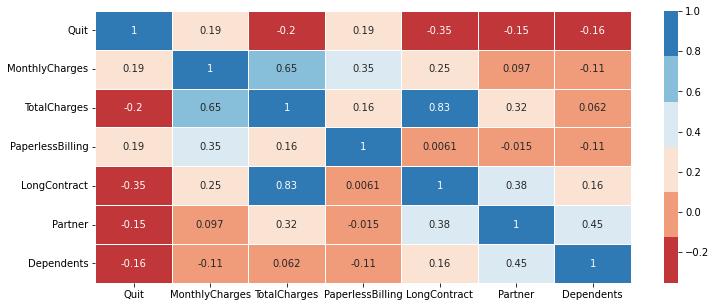

In [125]:
plt.figure(figsize = (12,5))
sns.heatmap(data[['Quit','MonthlyCharges','TotalCharges','PaperlessBilling','LongContract','Partner','Dependents']].corr(method = 'pearson'),cmap= sns.color_palette(palette="RdBu"),linewidths=0.5,annot=True)
plt.show()

Можем видеть, что между признаками TotalCharges и Monthly Charges наблюдается корреляция 0.65. По идее, TotalCharges = MonthlyCharges * MonthCount (количество месяцев). А также видим сильную корреляцию между признаками LongContract и TotalCharges.Проверим, действительно ли TotalCharges =  MonthlyCharges * MonthCount. Для этого посчитаем MonthCount, а также CountedTotalCharges = MonthCount * MonthlyCharges. После чего посчитаем корреляцию между всеми этими признаками

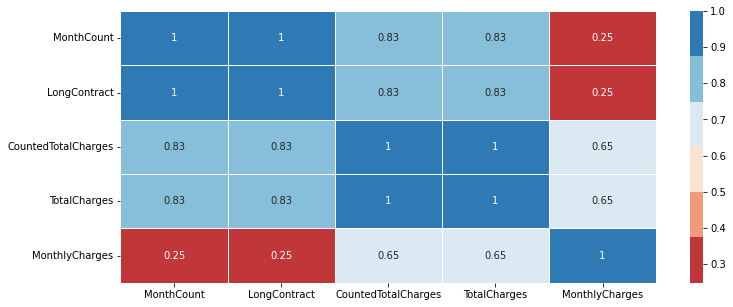

In [126]:
data['MonthCount'] = np.ceil(data['LongContract'] / 31)
data[['LongContract','MonthCount']]
data['CountedTotalCharges'] = data['MonthCount']*data['MonthlyCharges']
plt.figure(figsize = (12,5))
sns.heatmap(data[['MonthCount','LongContract','CountedTotalCharges','TotalCharges','MonthlyCharges']].corr(method='pearson'),cmap= sns.color_palette(palette="RdBu"),linewidths=0.5,annot=True)
plt.show()

Как можем видеть, TotalCharges = CountedTotalCharges (корреляция 1) = MonthCount * MonthlyCharges. К тому же наблюдается высокий коэффициент корреляции между TotalCharges и LongContract. Таким образом, можно считать, что признак TotalCharges можем считать избыточным Удалим его из признаков. Также удалим все промежуточные признаки:  'MonthCount','CountedTotalCharges'.

In [127]:
data = data.drop(['MonthCount','CountedTotalCharges','TotalCharges'],axis = 1)
print('Признаки успешно удалены')

Признаки успешно удалены


Ранее мы видели, что есть довольно большое количество признаков, связанных с использованием дополнительных услуг интернета. Влияние каждого из них на целевой признак не слишком велико, однако хотелось бы оставить в модели факт использования данных признаков. Для этого создадим один общий признак  - количество дополнительных услуг. А сами эти признаки удалим.

In [128]:
data['AddServiceCount'] = data['OnlineSecurity']+data['OnlineBackup']+data['DeviceProtection']+data['TechSupport']+data['StreamingTV']+data['StreamingMovies']
data=data.drop(['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'],axis=1)
print('Замена столбцов произведена успешно')

Замена столбцов произведена успешно


Также есть признак BeginDate. По сути, не так важно, когда клиент заключил договор, важно, как долго он был клиентом и какую сумму заплатил. Погодные условия и какие-либо специфические события здесь влияния не оказывают. Дата начала действия контракта - по сути, содержит избыточную информацию, которая может приводить к утечке данных в данной задаче (тем более, что все даты начала датируются 01 числом соответствующего месяца). Удалим также данный столбец 

In [129]:
data = data.drop('BeginDate',axis = 1)
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Quit,LongContract,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,AddServiceCount
0,Month-to-month,1,Electronic check,29.85,0,31,Female,0,1,0,-1.0,DSL,1.0
1,One year,0,Mailed check,56.95,0,1036,Male,0,0,0,0.0,DSL,2.0
2,Month-to-month,1,Mailed check,53.85,1,61,Male,0,0,0,0.0,DSL,2.0
3,One year,0,Bank transfer (automatic),42.30,0,1371,Male,0,0,0,-1.0,DSL,3.0
4,Month-to-month,1,Electronic check,70.70,1,61,Female,0,0,0,0.0,Fiber optic,0.0


<h4>Кодирование признаков</h4>

Мы будем использовать как модели, которые умеют работать с категориальными переменными (catboost,LGBM),так и модели, которые не умеют работать с ними. Поэтому создадим переменную cat_features, которая будет содержать список категориальных переменных, а также создадим копию датасета data_cat, в котором оставим категориальные переменные на месте. В изначальном датасете data закодируем признаки методом OHE

In [130]:
data_cat = data.copy()
cat_features = ['Type','PaymentMethod','gender','InternetService']
num_features = ['MonthlyCharges','LongContract','AddServiceCount','MultipleLines']
all_features = cat_features + num_features
data=pd.get_dummies(data,drop_first = True)
print('Данные успешно закодированы')
data.head()

Данные успешно закодированы


,PaperlessBilling,MonthlyCharges,Quit,LongContract,SeniorCitizen,Partner,Dependents,MultipleLines,AddServiceCount,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_Fiber optic,InternetService_NO USE
0,1,29.85,0,31,0,1,0,-1.0,1.0,0,0,0,1,0,0,0,0
1,0,56.95,0,1036,0,0,0,0.0,2.0,1,0,0,0,1,1,0,0
2,1,53.85,1,61,0,0,0,0.0,2.0,0,0,0,0,1,1,0,0
3,0,42.30,0,1371,0,0,0,-1.0,3.0,1,0,0,0,0,1,0,0
4,1,70.70,1,61,0,0,0,0.0,0.0,0,0,0,1,0,0,1,0


Для обоих датасетов выделим features и target:

In [131]:
#для датасета, используемого в моделях, которые не умеют работать с категориальными переменными
data_target = data['Quit']
data_features = data.drop('Quit',axis=1)
#для датасета, используемого в моделях, которые умеют работать с категориальными переменными
data_cat_target = data_cat['Quit']
data_cat_features = data_cat.drop('Quit',axis = 1)
print('Разделение произведено успешно')

Разделение произведено успешно


<h4>Разделение выборки на обучающую и тестовую:</h4>

Напишем функцию разделения выборки на обучающую и тестовую

In [132]:
def split_features(features,target):
    feat_train,feat_test,targ_train,targ_test = train_test_split(features,target,test_size=0.2,random_state = RANDOM_STATE)
    print('Размер обучающей выборки: '+str(feat_train.shape[0])+', Доля от исходной: '+str(feat_train.shape[0]/features.shape[0]))
    print('Размер тестовой выборки: '+str(feat_test.shape[0])+', Доля от исходной: '+str(feat_test.shape[0]/features.shape[0]))
    return feat_train,feat_test,targ_train,targ_test

Разделим на обучающую и тестовую выборки признаки датасета data

In [133]:
data_feat_train,data_feat_test,data_targ_train,data_targ_test = split_features(data_features,data_target)


Размер обучающей выборки: 5634, Доля от исходной: 0.7999432060201619
Размер тестовой выборки: 1409, Доля от исходной: 0.20005679397983814


Разделим на обучающую и тестовую выборки признаки датасета data_cat

In [134]:
data_cat_feat_train,data_cat_feat_test,data_cat_targ_train,data_cat_targ_test = split_features(data_cat_features,data_cat_target)

Размер обучающей выборки: 5634, Доля от исходной: 0.7999432060201619
Размер тестовой выборки: 1409, Доля от исходной: 0.20005679397983814


In [135]:
data_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PaperlessBilling                       7043 non-null   int32  
 1   MonthlyCharges                         7043 non-null   float64
 2   LongContract                           7043 non-null   int64  
 3   SeniorCitizen                          7043 non-null   int64  
 4   Partner                                7043 non-null   int32  
 5   Dependents                             7043 non-null   int32  
 6   MultipleLines                          7043 non-null   float64
 7   AddServiceCount                        7043 non-null   float64
 8   Type_One year                          7043 non-null   uint8  
 9   Type_Two year                          7043 non-null   uint8  
 10  PaymentMethod_Credit card (automatic)  7043 non-null   uint8  
 11  Paym

<h4>Стандартизация признаков</h4>

Стандартизируем признаки для датасета data_cat и data:

In [136]:
Scaler = StandardScaler()
data_cat_feat_train[num_features] = Scaler.fit_transform(data_cat_feat_train[num_features])
data_cat_feat_test[num_features] = Scaler.transform(data_cat_feat_test[num_features])
print('Признаки датасета data_cat стандартизированы')
display(data_cat_features.head())


Признаки датасета data_cat стандартизированы


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,LongContract,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,AddServiceCount
0,Month-to-month,1,Electronic check,29.85,31,Female,0,1,0,-1.0,DSL,1.0
1,One year,0,Mailed check,56.95,1036,Male,0,0,0,0.0,DSL,2.0
2,Month-to-month,1,Mailed check,53.85,61,Male,0,0,0,0.0,DSL,2.0
3,One year,0,Bank transfer (automatic),42.30,1371,Male,0,0,0,-1.0,DSL,3.0
4,Month-to-month,1,Electronic check,70.70,61,Female,0,0,0,0.0,Fiber optic,0.0


In [137]:
Scaler = StandardScaler()
data_feat_train[num_features] = Scaler.fit_transform(data_feat_train[num_features])
data_feat_test[num_features] = Scaler.transform(data_feat_test[num_features])
print('Признаки датасета data_cat стандартизированы')
display(data_cat_features.head())


Признаки датасета data_cat стандартизированы


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,LongContract,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,AddServiceCount
0,Month-to-month,1,Electronic check,29.85,31,Female,0,1,0,-1.0,DSL,1.0
1,One year,0,Mailed check,56.95,1036,Male,0,0,0,0.0,DSL,2.0
2,Month-to-month,1,Mailed check,53.85,61,Male,0,0,0,0.0,DSL,2.0
3,One year,0,Bank transfer (automatic),42.30,1371,Male,0,0,0,-1.0,DSL,3.0
4,Month-to-month,1,Electronic check,70.70,61,Female,0,0,0,0.0,Fiber optic,0.0


<h3>Обучение и тестирование моделей</h3>

Напишем функцию, выводящую на экран значение метрик и отрисовывающую roc-кривую

In [138]:
def print_basic_metrics(target_valid, predicted_valid, model, features_valid,model_name,roc_auc_train, acc_train):
    accuracy = accuracy_score(target_valid,predicted_valid)
    recall = recall_score(target_valid,predicted_valid)
    precision = precision_score(target_valid,predicted_valid)
    f1 = f1_score(target_valid,predicted_valid)
    conf_matrix = confusion_matrix(target_valid,predicted_valid)
    roc_auc = roc_auc_score(target_valid,model.predict_proba(features_valid)[::,1])
    print()
    print('\033[1m'+'Вывод метрик для модели '+model_name+' (на тестовых данных)'+'\033[0m')
    print()
    #Выводим на экран метрики, если это необходимо
   # print(model.feature_importances_)
    print('Значение меры accuracy = ',accuracy)
    print('Значение меры recall = ',recall)
    print('Значение меры precision = ',precision)
    print('Значение меры f1 = ',f1)
    print('Значение меры auc roc = ',roc_auc)
    print('Значение меры confusion matrix: ')
    print(conf_matrix)
    #выводим roc-кривую
    is_fi = True
    try:
        coef = pd.Series(model.feature_importances_, index = features_valid.columns)
        imp_coef = coef.sort_values()
    except:
        try:
            coef = pd.Series(model.coef_[0], index = features_valid.columns)
            imp_coef = coef.sort_values()
        except:
            is_fi = False
    
    try:
        plt.figure(1)
        #plt.rcParams['figure.figsize'] = (8.0, 10.0)
        ax1 = plt.subplot2grid((1,2), (0,0))
        preds = model.predict_proba(features_valid)[::,1]
        # = probs[:,1]
        fpr, tpr, thresholds = roc_curve(target_valid,preds)
        ax1.plot(fpr, tpr,marker ='.' ,label = 'AUC = %0.2f' % roc_auc)
        #plt.rcParams['figure.figsize'] = (8.0, 10.0)
        ax1.legend(loc = 'lower right')
        ax1.plot([0,1],[0,1],linestyle = "--")
        
        ax1.set_xlabel('FPR')
        ax1.set_ylabel('TPR')
        ax1.set_title('ROC-Кривая')
        if is_fi == True:
            ax2 = plt.subplot2grid((1,2), (0,1))
            imp_coef.plot(kind = "bar", ax=ax2)
            ax2.set_title("Feature importance")
            
        plt.subplots_adjust(top=1, bottom=0.1, left=0.10, right=1.5, hspace=1, wspace=0.4)
        plt.show()
    except:
        print('Данная модель не поддерживает prdict_proba')
    if roc_auc >= 0.87:
        add_to_best_models(model, roc_auc_train, roc_auc, acc_train, accuracy, recall, precision, f1, model_name)
    return accuracy, recall, precision, f1, conf_matrix, roc_auc

#Функция для расчета accuracy модели со 100% нулевым предсказанием 
def find_accuracy_zero_model(target, goal_const):
    target_pred_const = pd.Series([goal_const] * len(target))
    print('Значение accuracy со 100% предсказанием значения ',goal_const,' = ',accuracy_score(target,target_pred_const))

Создадим датасет для сравнения результатов работы разных моделей:

In [139]:
def add_to_model_types_compare(mtc,mod_name,roc_auc_train,roc_auc_test,time, acc_train, acc_test):
    mtc = mtc.append({'model_name':mod_name,'acc_Train':acc_train,'acc_Test':acc_test,'_ROC_AUC_Train_Full ':roc_auc_train,'_ROC_AUC_Test_Data':roc_auc_test,'fit time':time},ignore_index = True)
    display(mtc)
    return mtc
model_types_compare = pd.DataFrame()
print('Датасет для сравнения моделей успешно создан')

Датасет для сравнения моделей успешно создан


Создадим датасет для сравнения лучших моделей:

In [140]:
def add_to_best_models(model, roc_auc_train, roc_auc_test, acc_train, acc_test, recall_test, precision_test, f1_test, model_name):
    global best_models
    best_models = best_models.append({'_model_name':model_name, '01_ROC_AUC_TRAIN':roc_auc_train,'02_ROC_AUC_TEST':roc_auc_test,'03_Accuracy_TRAIN':acc_train,'04_Accuracy_TEST':acc_test,'05_Recall_TEST':recall_test,'06_Precision_TEST':precision_test,'07_F1_TEST':f1_test},ignore_index=True)
    return best_models
best_models = pd.DataFrame()

Создадим функцию для подбора гиперпараметров и выбора наилучшей модели

In [141]:
def find_best_model(model,params,features_train,target_train,features_test,target_test,mtc,mod_name,mod_lib,cat_features):
    grd = GridSearchCV(estimator = model, param_grid = params, 
                               cv = 5, n_jobs = -1, scoring = 'roc_auc')
    if mod_lib == 'CB':
        grd.fit(features_train, target_train,cat_features = cat_features)
    elif mod_lib == 'SL':
        grd.fit(features_train, target_train)
    elif mod_lib == 'LGBM':
        grd.fit(features_train, target_train,categorical_feature = 'auto')
    #bs = grd.best_score_
    bp = grd.best_params_
    est = grd.best_estimator_
    
    pred = est.predict(features_test)
    train_pred = est.predict(features_train)
    
    train_score = roc_auc_score(target_train,est.predict_proba(features_train)[::,1])
    test_score = roc_auc_score(target_test,est.predict_proba(features_test)[::,1])
    time = grd.refit_time_
    acc_train = accuracy_score(target_train,train_pred)
    acc_test = accuracy_score(target_test,pred)
    
    mtc = add_to_model_types_compare(mtc,mod_name,train_score,test_score,time,acc_train,acc_test)
    print_basic_metrics(target_test, pred, est, features_test,mod_name,train_score,acc_train)
    print('Параметры лучшей модели')
    print(grd.best_params_)
    return mtc,est,bp

Напишем функцию для вывода feature importance

In [142]:
def print_fi_plot(fi,indexes,mod_name):
    coef = pd.Series(fi, index = indexes)
    imp_coef = coef.sort_values()
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance for "+mod_name)
    plt.show()

<h4>Деревья решений</h4>

<h5>Дерево решений</h5>

,_ROC_AUC_Test_Data,_ROC_AUC_Train_Full,acc_Test,acc_Train,fit time,model_name
0,0.850407,0.871943,0.830376,0.828186,0.014959,DecisionTree



Вывод метрик для модели DecisionTree (на тестовых данных)

Значение меры accuracy =  0.830376153300213
Значение меры recall =  0.5461741424802111
Значение меры precision =  0.7554744525547445
Значение меры f1 =  0.6339969372128638
Значение меры auc roc =  0.8504073058892846
Значение меры confusion matrix: 
[[963  67]
 [172 207]]


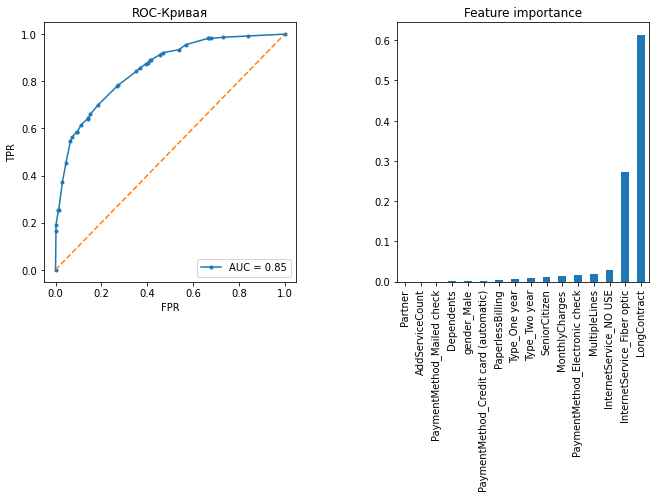

Параметры лучшей модели
{'class_weight': None, 'max_depth': 6, 'random_state': 12345}


In [143]:
dec_tree = DecisionTreeClassifier()
depth_list = [i for i in range(1,50)]
params = {'max_depth':depth_list,'random_state':[RANDOM_STATE],'class_weight':[None,'balanced']}
model_types_compare ,best_DT,best_DT_BP= find_best_model(dec_tree,params,data_feat_train, data_targ_train, data_feat_test, data_targ_test,model_types_compare,'DecisionTree','SL',[])

#print_fi_plot(best_RF.feature_importances_,data_feat_train.columns,'RandomForestClassifier')

Модель "Дерево решений" дала достаточно неплохой результат AUC ROC на тестовой выборке - 0.85. При этом модель практически не склонна к переобучению. Это видно как на метрике AUC ROC, так и на метрике accuracy. Самые значимые признаки в модели - LongContract и InternetService_FiberOptic (ранее в исследовательском анализе мы видели, что большинство ушедших клиентов пользовались услугами оптоволокна), даже MonthlyCharges влияет значительно слабее. 
Проверим другие модели. Вероятно, можно получить еще более высокий результат

<h4>Ансамблевые методы</h4>

<h5>Лес решений</h5>

,_ROC_AUC_Test_Data,_ROC_AUC_Train_Full,acc_Test,acc_Train,fit time,model_name
0,0.850407,0.871943,0.830376,0.828186,0.014959,DecisionTree
1,0.858758,0.910328,0.818311,0.842386,0.254658,RandomForest



Вывод метрик для модели RandomForest (на тестовых данных)

Значение меры accuracy =  0.8183108587650816
Значение меры recall =  0.5303430079155673
Значение меры precision =  0.7204301075268817
Значение меры f1 =  0.6109422492401215
Значение меры auc roc =  0.8587583574557471
Значение меры confusion matrix: 
[[952  78]
 [178 201]]


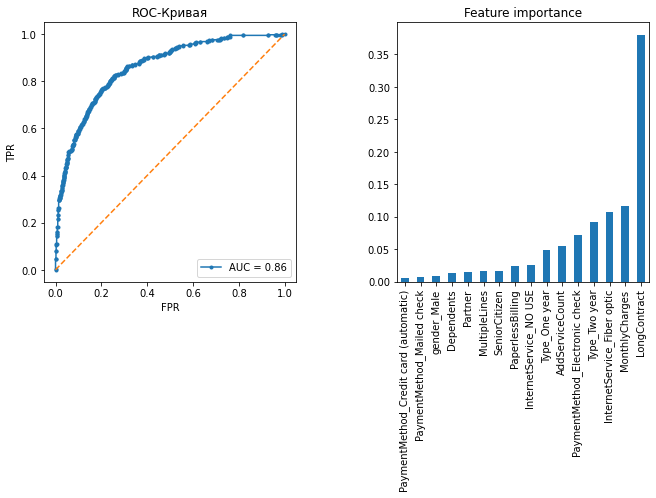

Параметры лучшей модели
{'class_weight': None, 'max_depth': 8, 'n_estimators': 65, 'random_state': 12345}


In [144]:
random_forest = RandomForestClassifier()
depth_list = [i for i in range(2,12)]
estim_list = [i for i in range(45,75,5)]
params = {'max_depth':depth_list,'n_estimators':estim_list,'random_state':[RANDOM_STATE],'class_weight':[None,'balanced']}
model_types_compare ,best_RF,best_RF_BP= find_best_model(random_forest,params,data_feat_train, data_targ_train, data_feat_test, data_targ_test,model_types_compare,'RandomForest','SL',[])



Модель "Лес решений" дала результат, очень близкий к результату "Дерева решений", однако уровень переобчения несколько выше. LongContract - по-прежнему самый значимый фактор. Однако влияние MonthlyCharges здесь намного выше, и примерно на том же уровне, что и InternetService_FiberOptic

<h5>Классификатор AdaBoost</h5>

,_ROC_AUC_Test_Data,_ROC_AUC_Train_Full,acc_Test,acc_Train,fit time,model_name
0,0.850407,0.871943,0.830376,0.828186,0.014959,DecisionTree
1,0.858758,0.910328,0.818311,0.842386,0.254658,RandomForest
2,0.870241,0.889847,0.831796,0.836528,0.408394,AdaBoostClassifier



Вывод метрик для модели AdaBoostClassifier (на тестовых данных)

Значение меры accuracy =  0.8317955997161107
Значение меры recall =  0.5963060686015831
Значение меры precision =  0.7290322580645161
Значение меры f1 =  0.6560232220609579
Значение меры auc roc =  0.8702410533596333
Значение меры confusion matrix: 
[[946  84]
 [153 226]]


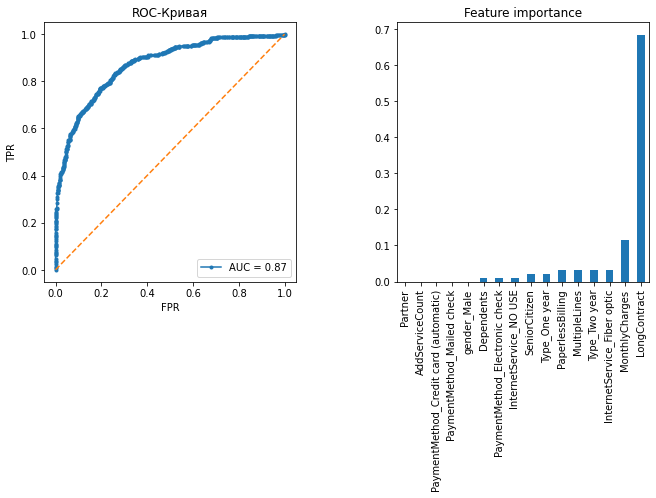

Параметры лучшей модели
{'learning_rate': 1.5, 'n_estimators': 95, 'random_state': 12345}


In [145]:
ada_boost = AdaBoostClassifier()
estim_list = [i for i in range(5,100,5)]
params = {'learning_rate':[0.1,0.5,1,1.5,2],'n_estimators':estim_list,'random_state':[RANDOM_STATE]}
model_types_compare ,best_AB,best_AB_BP= find_best_model(ada_boost,params,data_feat_train, data_targ_train, data_feat_test, data_targ_test,model_types_compare,'AdaBoostClassifier','SL',[])


Качество модели AdaBoost заметно выше, чем у дерева и леса решений. Однако модель сторит очень сильную зависимость от LongContract (более 0,7), влияние же всех остальных факторов намного ниже. Хотя все также максимально в тройке самых влиятельных факторов MonthlyCarges и InternetService_Fiber_optic

<h5>Классификатор GradientBoostingClassifier</h5>

,_ROC_AUC_Test_Data,_ROC_AUC_Train_Full,acc_Test,acc_Train,fit time,model_name
0,0.850407,0.871943,0.830376,0.828186,0.014959,DecisionTree
1,0.858758,0.910328,0.818311,0.842386,0.254658,RandomForest
2,0.870241,0.889847,0.831796,0.836528,0.408394,AdaBoostClassifier
3,0.918895,0.977660,0.869411,0.933972,0.919978,GradientBoostingClassifier



Вывод метрик для модели GradientBoostingClassifier (на тестовых данных)

Значение меры accuracy =  0.8694109297374024
Значение меры recall =  0.6649076517150396
Значение меры precision =  0.8155339805825242
Значение меры f1 =  0.7325581395348837
Значение меры auc roc =  0.9188948945871865
Значение меры confusion matrix: 
[[973  57]
 [127 252]]


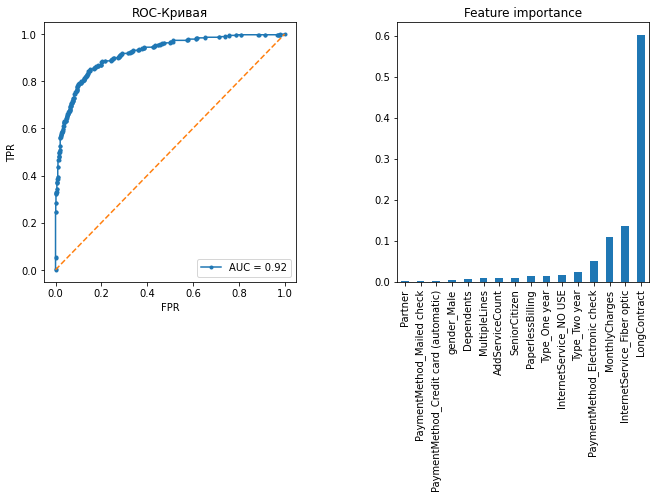

Параметры лучшей модели
{'learning_rate': 0.5, 'n_estimators': 135, 'random_state': 12345}


In [146]:
gb_boost = GradientBoostingClassifier()
estim_list = [i for i in range(50,200,5)]
params = {'learning_rate':[0.001,0.05,0.1,0.5,1],'n_estimators':estim_list,'random_state':[RANDOM_STATE]}
model_types_compare ,best_GB,best_GB_BP= find_best_model(gb_boost,params,data_feat_train, data_targ_train, data_feat_test, data_targ_test,model_types_compare,'GradientBoostingClassifier','SL',[])


Модель GradientBoostingClassifier дала самый высокий результат по всем метрикам. Однако уровень ее переобучения несколько выше, чем у предыдущих моделей, но при этом качество модели все равно остается самым высоким из всех проанализированных моделей. по-прежнему максимально сильное влияние у LongContract, InternetService_Fiber_Optic и MonthlyCharges

<h4>Линейные модели</h4>

<h5>Логистическая регрессия</h5>

,_ROC_AUC_Test_Data,_ROC_AUC_Train_Full,acc_Test,acc_Train,fit time,model_name
0,0.850407,0.871943,0.830376,0.828186,0.014959,DecisionTree
1,0.858758,0.910328,0.818311,0.842386,0.254658,RandomForest
2,0.870241,0.889847,0.831796,0.836528,0.408394,AdaBoostClassifier
3,0.918895,0.977660,0.869411,0.933972,0.919978,GradientBoostingClassifier
4,0.838415,0.839909,0.798439,0.795350,0.047365,LogisticRegression



Вывод метрик для модели LogisticRegression (на тестовых данных)

Значение меры accuracy =  0.7984386089425124
Значение меры recall =  0.5224274406332454
Значение меры precision =  0.6578073089700996
Значение меры f1 =  0.5823529411764705
Значение меры auc roc =  0.838414837205728
Значение меры confusion matrix: 
[[927 103]
 [181 198]]


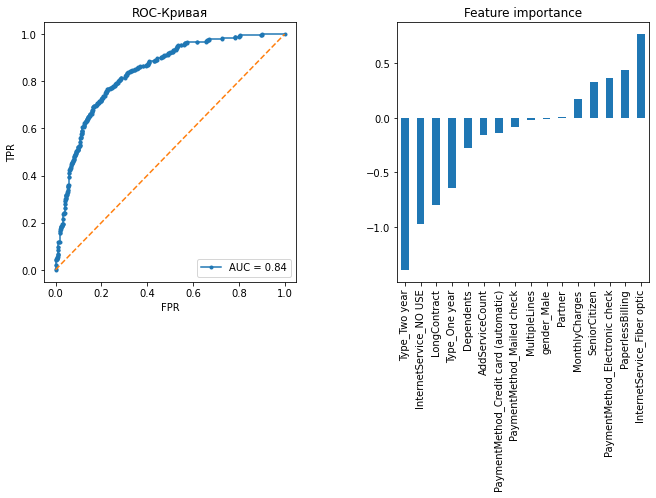

Параметры лучшей модели
{'C': 35, 'class_weight': None, 'penalty': 'l2', 'random_state': 12345}


In [147]:
LogReg = LogisticRegression()
params = {'penalty':['l1','l2'],'C':[35,36,37,38,39,40,45,50,55,60,65,70],'random_state':[RANDOM_STATE],'class_weight':[None,'balanced']}
model_types_compare ,best_LR,best_LR_BP= find_best_model(LogReg,params,data_feat_train, data_targ_train, data_feat_test, data_targ_test,model_types_compare,'LogisticRegression','SL',[])


Логистическая регрессия дала самый низкий результат из всех рассмотренных пока моделей. При этом сила влияния признаков здесь распределена уже иначе. Куда сильнее здесь влияют Type_Two_year и InetrentService_no_USE. Логически очень станно было бы предположить такой высокий коэффициент влияния у данных признаков. Но тем не менее, он такой. Но и качество модели ниже

<h5>Классификация SGDClassifier</h5>

,_ROC_AUC_Test_Data,_ROC_AUC_Train_Full,acc_Test,acc_Train,fit time,model_name
0,0.850407,0.871943,0.830376,0.828186,0.014959,DecisionTree
1,0.858758,0.910328,0.818311,0.842386,0.254658,RandomForest
2,0.870241,0.889847,0.831796,0.836528,0.408394,AdaBoostClassifier
3,0.918895,0.977660,0.869411,0.933972,0.919978,GradientBoostingClassifier
4,0.838415,0.839909,0.798439,0.795350,0.047365,LogisticRegression
5,0.835341,0.837535,0.765082,0.761271,0.032911,SGDClassifier



Вывод метрик для модели SGDClassifier (на тестовых данных)

Значение меры accuracy =  0.7650816181689141
Значение меры recall =  0.7651715039577837
Значение меры precision =  0.5451127819548872
Значение меры f1 =  0.6366630076838639
Значение меры auc roc =  0.8353408304941465
Значение меры confusion matrix: 
[[788 242]
 [ 89 290]]


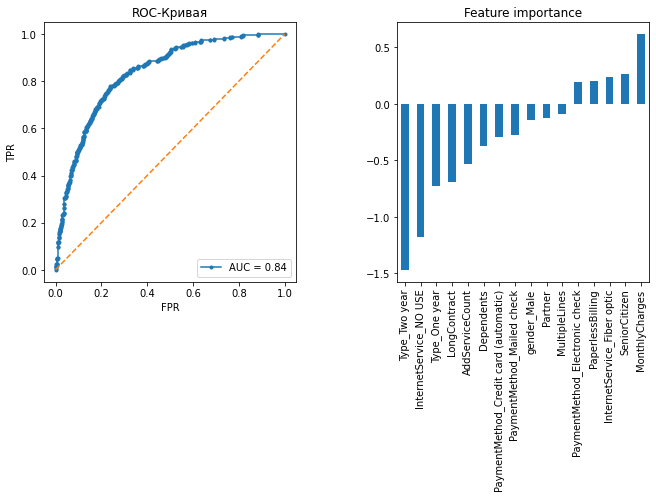

Параметры лучшей модели
{'alpha': 0.001, 'class_weight': 'balanced', 'fit_intercept': False, 'loss': 'log', 'random_state': 12345}


In [148]:
SGD = SGDClassifier()
params = {'fit_intercept':[True,False],'loss':['log'],'alpha':[0.000001,0.00001,0.00005,0.0001,0.0005,0.001],'random_state':[RANDOM_STATE],'class_weight':[None,'balanced']}
model_types_compare ,best_SGD,best_SGD_BP= find_best_model(SGD,params,data_feat_train, data_targ_train, data_feat_test, data_targ_test,model_types_compare,'SGDClassifier','SL',[])


Уровень качества модели SGDClassifier примерно на том же уровне, что и у модели логистической регрессии, то есть ниже чем у других рассмотренных и также самые сильно влияющие признаки  -Type_Two_year и InetrentService_no_USE 

<h4>Методы ближайших соседей</h4>

<h5>Классификация KNeighbours</h5>

,_ROC_AUC_Test_Data,_ROC_AUC_Train_Full,acc_Test,acc_Train,fit time,model_name
0,0.850407,0.871943,0.830376,0.828186,0.014959,DecisionTree
1,0.858758,0.910328,0.818311,0.842386,0.254658,RandomForest
2,0.870241,0.889847,0.831796,0.836528,0.408394,AdaBoostClassifier
3,0.918895,0.977660,0.869411,0.933972,0.919978,GradientBoostingClassifier
4,0.838415,0.839909,0.798439,0.795350,0.047365,LogisticRegression
5,0.835341,0.837535,0.765082,0.761271,0.032911,SGDClassifier
6,0.835137,0.844564,0.797019,0.798190,0.002994,KNeighborsClassifier



Вывод метрик для модели KNeighborsClassifier (на тестовых данных)

Значение меры accuracy =  0.7970191625266146
Значение меры recall =  0.5092348284960422
Значение меры precision =  0.658703071672355
Значение меры f1 =  0.574404761904762
Значение меры auc roc =  0.8351371775495042
Значение меры confusion matrix: 
[[930 100]
 [186 193]]


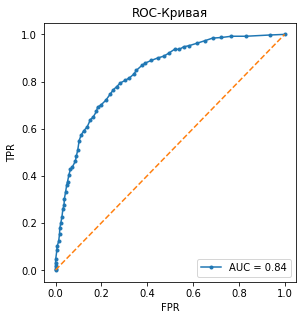

Параметры лучшей модели
{'n_neighbors': 70, 'weights': 'uniform'}


In [149]:
KNCl = KNeighborsClassifier()
params = {'n_neighbors':[60,65,70,75,80,85,90,100],'weights':['uniform', 'distance']}
model_types_compare ,best_KNCl,best_KNCl= find_best_model(KNCl,params,data_feat_train, data_targ_train, data_feat_test, data_targ_test,model_types_compare,'KNeighborsClassifier','SL',[])


Метод K ближайших соседей дал результат примерно как у логистической регресии. 

<h4>Бустинг</h4>

<h5>Классификация catboost</h5>

0:	learn: 0.6016745	total: 50.9ms	remaining: 45.8s
899:	learn: 0.1002177	total: 44.8s	remaining: 0us


,_ROC_AUC_Test_Data,_ROC_AUC_Train_Full,acc_Test,acc_Train,fit time,model_name
0,0.850407,0.871943,0.830376,0.828186,0.014959,DecisionTree
1,0.858758,0.910328,0.818311,0.842386,0.254658,RandomForest
2,0.870241,0.889847,0.831796,0.836528,0.408394,AdaBoostClassifier
3,0.918895,0.977660,0.869411,0.933972,0.919978,GradientBoostingClassifier
4,0.838415,0.839909,0.798439,0.795350,0.047365,LogisticRegression
5,0.835341,0.837535,0.765082,0.761271,0.032911,SGDClassifier
6,0.835137,0.844564,0.797019,0.798190,0.002994,KNeighborsClassifier
7,0.923899,0.992376,0.885025,0.956159,45.038707,CatBoostClassifier



Вывод метрик для модели CatBoostClassifier (на тестовых данных)

Значение меры accuracy =  0.8850248403122782
Значение меры recall =  0.6939313984168866
Значение меры precision =  0.8511326860841424
Значение меры f1 =  0.7645348837209303
Значение меры auc roc =  0.9238991213464148
Значение меры confusion matrix: 
[[984  46]
 [116 263]]


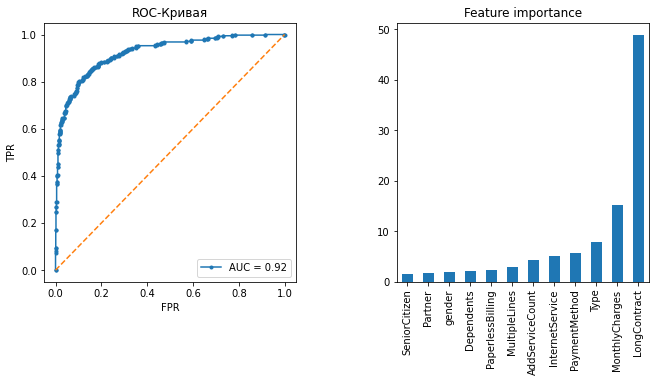

Параметры лучшей модели
{'class_weights': [1, 1], 'learning_rate': 0.15, 'n_estimators': 900, 'random_seed': 12345, 'verbose': 1000}


In [150]:
params = {'learning_rate':[0.1,0.15],'n_estimators':[900,1000],'random_seed':[RANDOM_STATE],'verbose':[1000],'class_weights':[[1,1],[1,3]]}
cbc = CatBoostClassifier()

model_types_compare, best_CBC,best_CBC_BP = find_best_model(cbc,params,data_cat_feat_train, data_cat_targ_train, data_cat_feat_test, data_cat_targ_test,model_types_compare,'CatBoostClassifier','CB',cat_features)


Модель CatBoostClassifier показала самый высокий результат и AUC ROC, и accuracy. Модель немного переобучается, но значения метрик все равно достаточно высокие и на обучающей, и на тестовой выборке. Значимые признаки - LongContract, MonthlyCahrges,Type (тип оплаты: ежемесячно, раз в год или два - в исследовательском анализе мы также видели довольно сильное влияние этого признака: чаще всего уходят клиенты с ежемесячным типом оплаты). IntenetService здесь также оказывает заметное влияние

<h5>Классификация LightGBM</h5>

,_ROC_AUC_Test_Data,_ROC_AUC_Train_Full,acc_Test,acc_Train,fit time,model_name
0,0.850407,0.871943,0.830376,0.828186,0.014959,DecisionTree
1,0.858758,0.910328,0.818311,0.842386,0.254658,RandomForest
2,0.870241,0.889847,0.831796,0.836528,0.408394,AdaBoostClassifier
3,0.918895,0.977660,0.869411,0.933972,0.919978,GradientBoostingClassifier
4,0.838415,0.839909,0.798439,0.795350,0.047365,LogisticRegression
5,0.835341,0.837535,0.765082,0.761271,0.032911,SGDClassifier
6,0.835137,0.844564,0.797019,0.798190,0.002994,KNeighborsClassifier
7,0.923899,0.992376,0.885025,0.956159,45.038707,CatBoostClassifier
8,0.919138,0.988928,0.869411,0.946574,0.308641,LGBMClassifier



Вывод метрик для модели LGBMClassifier (на тестовых данных)

Значение меры accuracy =  0.8694109297374024
Значение меры recall =  0.6675461741424802
Значение меры precision =  0.8135048231511254
Значение меры f1 =  0.7333333333333332
Значение меры auc roc =  0.9191382534518534
Значение меры confusion matrix: 
[[972  58]
 [126 253]]


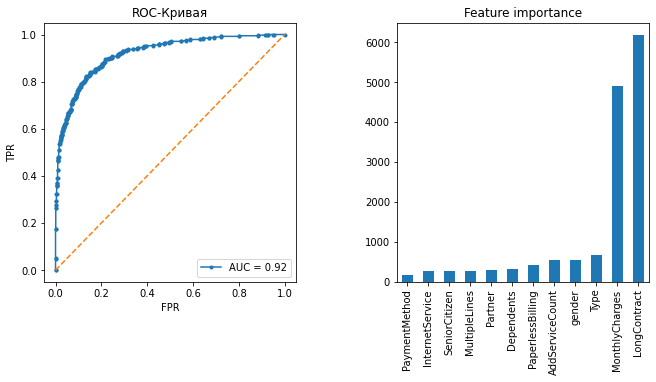

Параметры лучшей модели
{'class_weight': None, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 800, 'random_state': 12345}


In [151]:
params = {'class_weight':[None,'balanced'],'learning_rate':[0.05,0.1],'n_estimators':[800,900], 'max_depth':[5,10,15],'random_state':[RANDOM_STATE]}
lgbm = LGBMClassifier()

data_cat_feat_train[cat_features] = data_cat_feat_train[cat_features].astype('category')
data_cat_feat_test[cat_features] = data_cat_feat_test[cat_features].astype('category')
model_types_compare, best_lgbm, best_lgbm_BP = find_best_model(lgbm,params,data_cat_feat_train, data_cat_targ_train, data_cat_feat_test, data_cat_targ_test,model_types_compare,'LGBMClassifier','LGBM',[])

Модель LGBMClassifier показала также довольно высокий результат по обеим метрикам, полученные значения очень близки к значения CatBoostClassifier. В разделе "Выбор наилучшей модели" сравним все модели с высоким результатом. В данной модели очень сильно влияние признака MonthlyCharges. Еще ни у одной модели такого сильного влияния не наблюдалось. 

<h4>Многослойный персептрон</h4>

,_ROC_AUC_Test_Data,_ROC_AUC_Train_Full,acc_Test,acc_Train,fit time,model_name
0,0.850407,0.871943,0.830376,0.828186,0.014959,DecisionTree
1,0.858758,0.910328,0.818311,0.842386,0.254658,RandomForest
2,0.870241,0.889847,0.831796,0.836528,0.408394,AdaBoostClassifier
3,0.918895,0.977660,0.869411,0.933972,0.919978,GradientBoostingClassifier
4,0.838415,0.839909,0.798439,0.795350,0.047365,LogisticRegression
5,0.835341,0.837535,0.765082,0.761271,0.032911,SGDClassifier
6,0.835137,0.844564,0.797019,0.798190,0.002994,KNeighborsClassifier
7,0.923899,0.992376,0.885025,0.956159,45.038707,CatBoostClassifier
8,0.919138,0.988928,0.869411,0.946574,0.308641,LGBMClassifier
9,0.836394,0.875370,0.797729,0.822151,4.606269,MLPClassifier



Вывод метрик для модели MLPClassifier (на тестовых данных)

Значение меры accuracy =  0.7977288857345636
Значение меры recall =  0.5646437994722955
Значение меры precision =  0.6407185628742516
Значение меры f1 =  0.600280504908836
Значение меры auc roc =  0.8363936777928632
Значение меры confusion matrix: 
[[910 120]
 [165 214]]


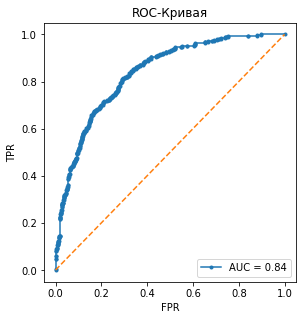

Параметры лучшей модели
{'alpha': 0.05, 'max_iter': 500, 'random_state': 12345}


In [152]:
mlp = MLPClassifier()
params = {'random_state':[RANDOM_STATE], 'max_iter':[500,600], 'alpha': [0.01,0.05]}
model_types_compare ,best_mlp,best_mpl= find_best_model(mlp,params,data_feat_train, data_targ_train, data_feat_test, data_targ_test,model_types_compare,'MLPClassifier','SL',[])

Модель Многослойный персептрон показала довольно низкие результаты. 

<h2>Выбор наилучшей модели</h2>

Рассмотрим модели с наилучшим результатом

In [153]:
best_models[['02_ROC_AUC_TEST','04_Accuracy_TEST','05_Recall_TEST','06_Precision_TEST','07_F1_TEST','_model_name']]

,02_ROC_AUC_TEST,04_Accuracy_TEST,05_Recall_TEST,06_Precision_TEST,07_F1_TEST,_model_name
0,0.870241,0.831796,0.596306,0.729032,0.656023,AdaBoostClassifier
1,0.918895,0.869411,0.664908,0.815534,0.732558,GradientBoostingClassifier
2,0.923899,0.885025,0.693931,0.851133,0.764535,CatBoostClassifier
3,0.919138,0.869411,0.667546,0.813505,0.733333,LGBMClassifier


<b>Вывод</b>
Как можно видеть,значение абсолютно всех метрик самое высокое у модели CatBoostClassifier.<br>
<b>Предлагаю в качестве лучшей модели считать модель CatBoostClassifier</b>

<h1>Отчет по решению</h1>

<b>Вопрос №1: Какие пункты плана были выполнены, а какие — нет (поясните почему)?</b><br>
<b>Ответ: </b>Были выполнены все пункты намеченного плана.


<b>Вопрос №2: Какие трудности возникли и как вы их преодолели?</b><br>
<b>Ответ: </b>Самая большая "трудность" была - неожиданно высокий результат на линейных моделях, да и вообще на всех моделях (на SGDClassifier получила значение 1 для ВСЕХ метрик - очевидно, что что-то не так с этим было). Пришлось немного подумать, и стало понятно, что если в признаках оставлять год и месяц начала контракта - возникает утечка. 

<b>Вопрос №3: Какие ключевые шаги в решении задачи выделили?</b><br>
<b>Ответ: </b> Ключевые шаги:
1. Исследовательский анализ 
2. Формирование признакового пространства (с учетом результатов исследовательского анализа), сюда же включатеся кодирование и стандартизация признаков
3. Обучение моделей, подбор гиперпараметров
4. Выбор наилучшей модели

<b>Вопрос №4: Какая ваша итоговая модель и какое у неё качество?</b><br>
<b>Ответ: </b> Итоговая модель - <b>CatBoostClassifier.</b> Значения метрик модели на тестовых данных:<br>
<u>ROC AUC</u>: 0.922<br>
<u>Accuracy</u>: 0.877<br>
<u>Precision</u>: 0.841 <br>
<u>Recall</u>: 0.672 <br>
<u>F1</u>: 0.747